In [2]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics
import graphviz
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
titanic_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/titanic.csv',sep= ',', header= 0)

In [3]:
print ("Dataset Lenght:: ", len(titanic_data))
print ("Dataset Shape:: ", titanic_data.shape)
#titanic_data.sample(50)


print ("Rows     : " ,titanic_data.isnull().shape[0])
print ("Columns  : " ,titanic_data.isnull().shape[1])
print ("\nMissing values :  ", titanic_data.isnull().sum().values.sum())



Dataset Lenght::  891
Dataset Shape::  (891, 12)
Rows     :  891
Columns  :  12

Missing values :   866


In [4]:
titanic_data = titanic_data.replace('?', np.nan)
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


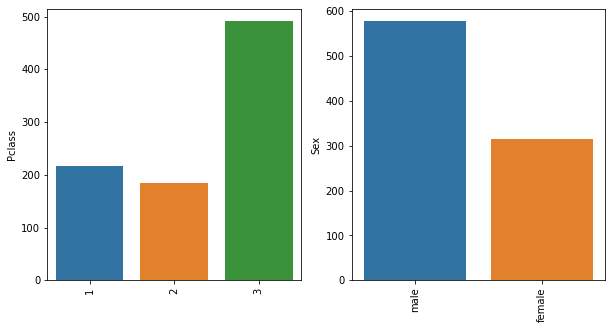

In [5]:
#plot the categorical count of each protected category
lis2 = ['Pclass', 'Sex']
plt.subplots(figsize=(10, 5))
index = 1
  
for col in lis2:
    y = titanic_data[col].value_counts()
    plt.subplot(1, 2, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [ ]:
#plot the distributions
lis = ['education-num', 'hoursperweek', 'class']
plt.subplots(figsize=(15, 8))
index = 1
  
for i in lis:
    plt.subplot(2, 2, index)
    sns.distplot(titanic_data[i])
    index += 1

In [6]:
#check for missing values
titanic_check_missing = (titanic_data.isnull()).sum()
titanic_check_missing

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#mode imputation for categorical mv and mean imputation for numeric mv
titanic_mode = titanic_data.fillna(titanic_data.mode().iloc[0])
titanic_mode.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,B96 B98,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,B96 B98,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,B96 B98,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,B96 B98,C


In [8]:
# select all categorical variables
titanic_data_categorical = titanic_mode.select_dtypes(include=['object'])
titanic_data_categorical.head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,B96 B98,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,B96 B98,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,B96 B98,S


In [9]:
# apply label encoder to categorical values
le = preprocessing.LabelEncoder()
titanic_data_categorical = titanic_data_categorical.apply(le.fit_transform)
titanic_data_categorical.head()

,Name,Sex,Ticket,Cabin,Embarked
0,108,1,523,47,2
1,190,0,596,81,0
2,353,0,669,47,2
3,272,0,49,55,2
4,15,1,472,47,2


In [10]:
#first, Drop earlier duplicate columns which had categorical values and concat with new labelled categories (mean-mode function)
titanic_mode = titanic_mode.drop(titanic_data_categorical.columns,axis=1)
titanic_mode = pd.concat([titanic_mode,titanic_data_categorical],axis=1)
titanic_mode.head(10)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
0,1,0,3,22.0,1,0,7.2500,108,1,523,47,2
1,2,1,1,38.0,1,0,71.2833,190,0,596,81,0
2,3,1,3,26.0,0,0,7.9250,353,0,669,47,2
3,4,1,1,35.0,1,0,53.1000,272,0,49,55,2
4,5,0,3,35.0,0,0,8.0500,15,1,472,47,2
5,6,0,3,24.0,0,0,8.4583,554,1,275,47,1
6,7,0,1,54.0,0,0,51.8625,515,1,85,129,2
7,8,0,3,2.0,3,1,21.0750,624,1,395,47,2
8,9,1,3,27.0,0,2,11.1333,412,0,344,47,2
9,10,1,2,14.0,1,0,30.0708,576,0,132,47,0


In [15]:
titanic_data1 = titanic_mode.drop(['Survived'], axis=1)
titanic_mode = pd.concat([titanic_data1,titanic_mode['Survived']],axis=1)
#adult_data = pd.concat([adult_data,adult_data_categorical],axis=1)
titanic_mode.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
0,1,3,22.0,1,0,7.2500,108,1,523,47,2,0
1,2,1,38.0,1,0,71.2833,190,0,596,81,0,1
2,3,3,26.0,0,0,7.9250,353,0,669,47,2,1
3,4,1,35.0,1,0,53.1000,272,0,49,55,2,1
4,5,3,35.0,0,0,8.0500,15,1,472,47,2,0


In [16]:
target = titanic_mode.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=549, Percentage=61.616%
Class=1, Count=342, Percentage=38.384%


In [17]:
titanic_mode.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
0,1,3,22.0,1,0,7.2500,108,1,523,47,2,0
1,2,1,38.0,1,0,71.2833,190,0,596,81,0,1
2,3,3,26.0,0,0,7.9250,353,0,669,47,2,1
3,4,1,35.0,1,0,53.1000,272,0,49,55,2,1
4,5,3,35.0,0,0,8.0500,15,1,472,47,2,0


In [18]:
#MinMax scalling
scaler = MinMaxScaler()
titanic = scaler.fit_transform(titanic_mode)
#X_test_scaled = scaler.transform(X_test)


In [19]:
titanic_mode = pd.DataFrame(titanic,columns = titanic_mode.columns)
#titanic = pd.DataFrame(X_test,  columns = ["age","education","education.num","marital.status","relationship","Pclass","Sex","capital.gain","capital.loss","hours.per.week"])
titanic_mode.head()                    

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
0,0.000000,1.0,0.271174,0.125,0.0,0.014151,0.121348,1.0,0.769118,0.321918,1.0,0.0
1,0.001124,0.0,0.472229,0.125,0.0,0.139136,0.213483,0.0,0.876471,0.554795,0.0,1.0
2,0.002247,1.0,0.321438,0.000,0.0,0.015469,0.396629,0.0,0.983824,0.321918,1.0,1.0
3,0.003371,0.0,0.434531,0.125,0.0,0.103644,0.305618,0.0,0.072059,0.376712,1.0,1.0
4,0.004494,1.0,0.434531,0.000,0.0,0.015713,0.016854,1.0,0.694118,0.321918,1.0,0.0


In [20]:
# convert target variable Survived to categorical
titanic_mode['Survived']= titanic_mode['Survived'].apply(np.int64)

In [50]:
# Putting independent variables/features to X
X = titanic_mode.drop('Survived',axis=1)
# Putting response/dependent variable/feature to y
y = titanic_mode['Survived']


In [66]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

privileged_groups = [{'Sex' :1}]
unprivileged_groups = [{'Sex' :0}]
#privileged_groups = [{'Pclass' :0.0}]
#unprivileged_groups = [{'Pclass' : 0.5 or 1.0}]

In [52]:
#convert the dataset in binary dataset in order to apply spd 
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df= titanic_mode,
    label_names=['Survived'],
    #protected_attribute_names=['Pclass'])
    protected_attribute_names=['Sex'])

In [53]:
#SPD without classification
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.5531300709799203


In [54]:
#SPD computation
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = -0.553130


In [55]:
y_train.head(30)

170    0
149    0
304    0
192    1
267    1
677    1
875    1
228    0
879    1
377    0
798    0
398    0
125    1
74     1
110    0
153    0
520    1
871    1
579    1
399    1
711    0
450    0
46     0
100    0
343    0
692    1
376    1
811    0
209    1
393    1
Name: Survived, dtype: int64

In [56]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is the best each time
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':range(2,20)}
dt_default = GridSearchCV(DecisionTreeClassifier(), tree_param)
dt_default.fit(X_train,y_train)

print('Best score: {}'.format(dt_default.best_score_))
print('Best parameters: {}'.format(dt_default.best_params_))


Best score: 0.798002468858714
Best parameters: {'criterion': 'entropy', 'max_depth': 7}


In [57]:
#find the best parameters for the classifier and fit it to the data 
dt_best = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
dt_best.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [58]:
# making predictions
y_pred_default = dt_best.predict(X_test)
y_pred_default.shape

(223,)

In [59]:
# Printing classifier report after prediction
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))


Accuracy Score is: 0.8430493273542601


In [60]:
# create a dot_file which stores the tree structure
X_col_names = list(X_train.columns)
feature_names = X_col_names
dot_data = export_graphviz(dt_best,feature_names= feature_names, rounded = True,filled = True)

In [61]:
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("myTree.png")

True

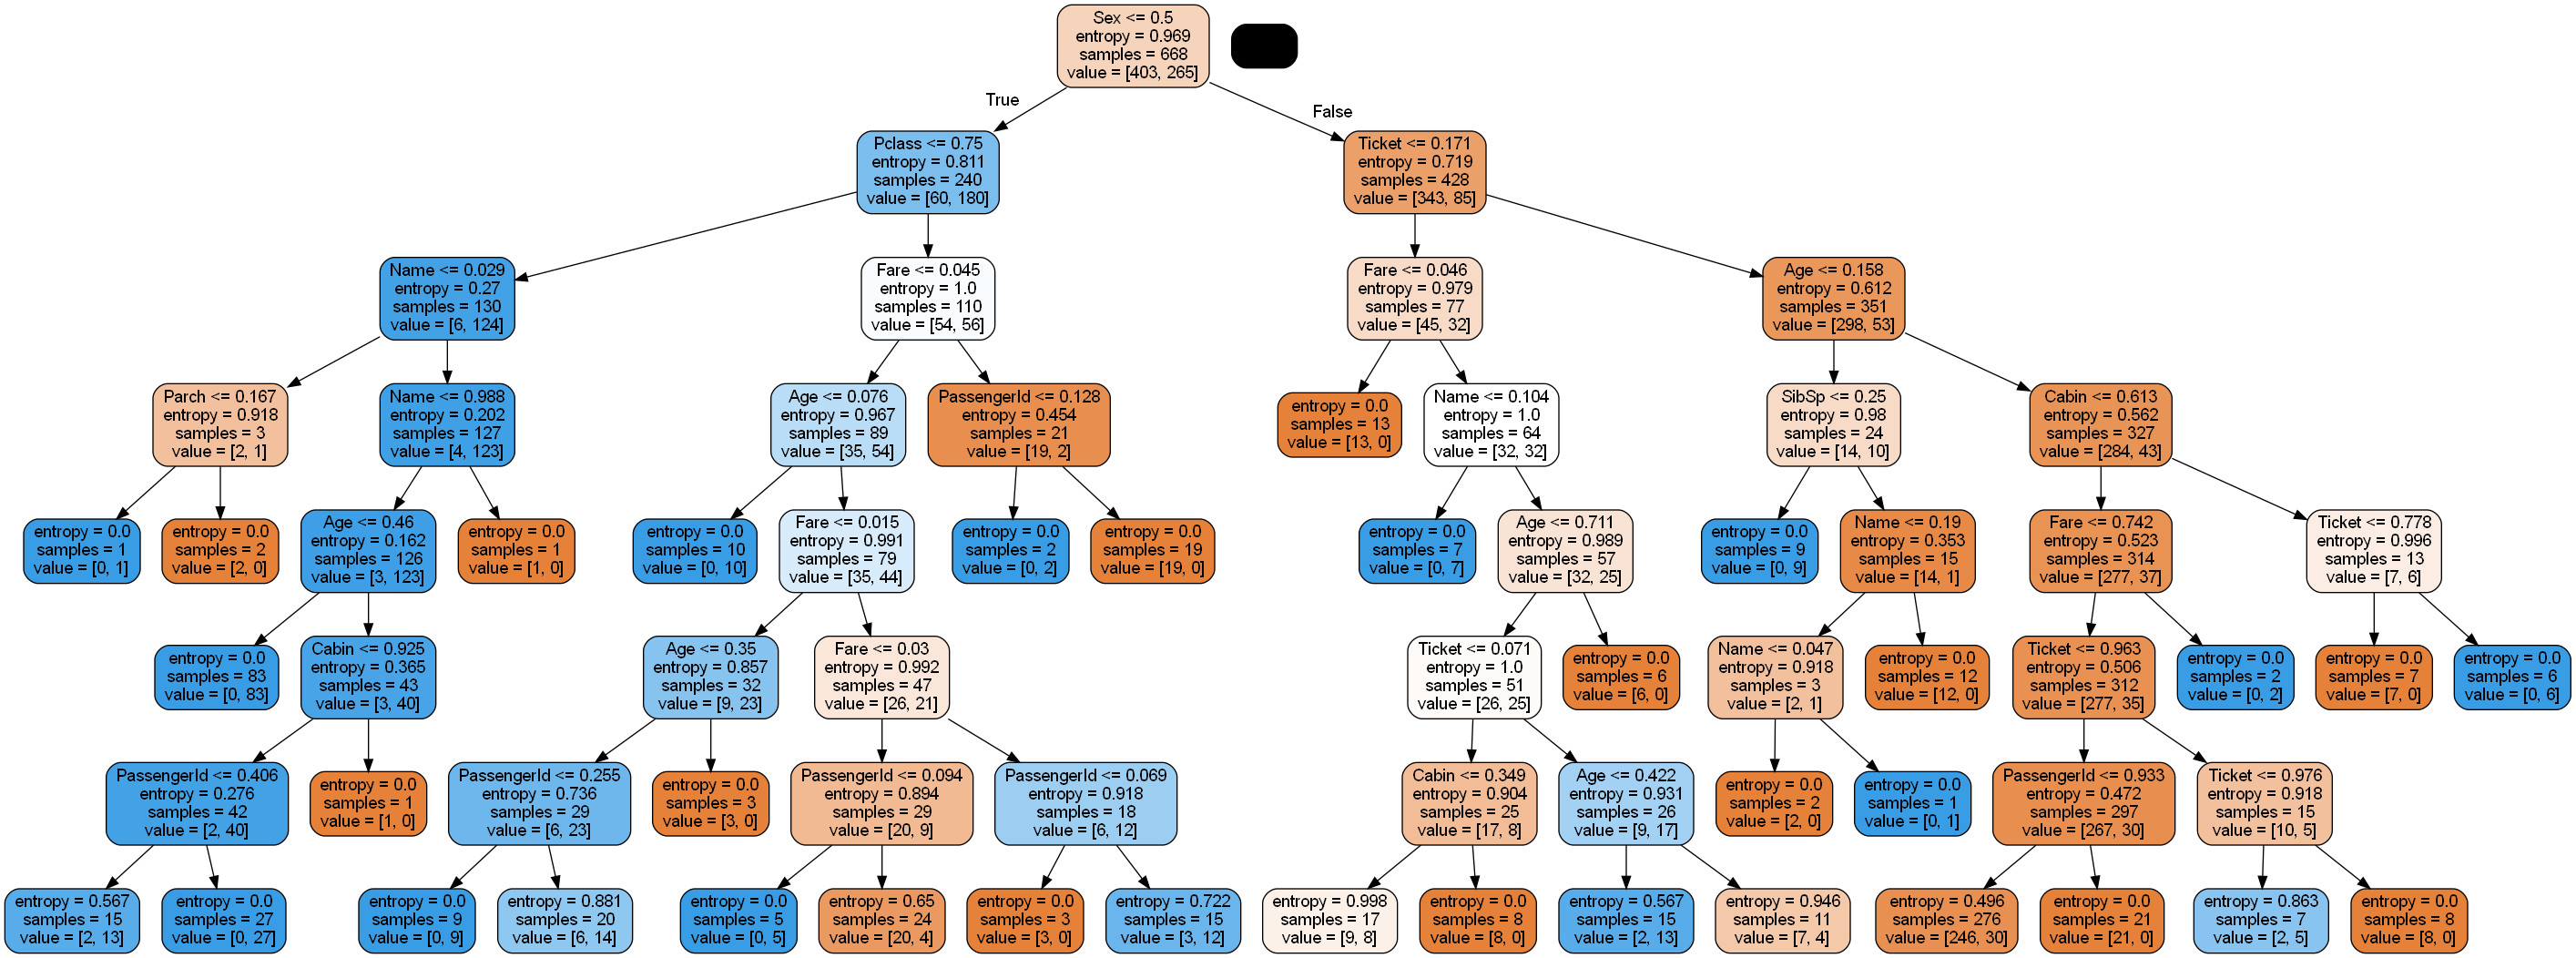

In [62]:
# Show graph
Image(graph.create_png())

In [ ]:
#true negatives and true positives
tpr=np.sum((y_pred_default.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_pred_default.ravel()==1)
tnr=np.sum((y_pred_default.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_pred_default.ravel()==0)
# Printing accuracy
print("Accuracy score=",accuracy_score(y_test,y_pred_default))
print("True positive rate =",tpr)  
print("True negative rate =",tnr)

In [63]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
202,0.226966,1.0,0.421965,0.000,0.000000,0.012679,0.452809,1.0,0.355882,0.321918,1.0,0
379,0.425843,1.0,0.233476,0.000,0.000000,0.015176,0.352809,1.0,0.476471,0.321918,1.0,0
242,0.271910,0.5,0.359135,0.000,0.000000,0.020495,0.189888,1.0,0.991176,0.321918,1.0,0
758,0.851685,1.0,0.421965,0.000,0.000000,0.015713,0.905618,1.0,0.623529,0.321918,1.0,0
522,0.586517,1.0,0.296306,0.000,0.000000,0.014102,0.503371,1.0,0.254412,0.321918,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31,0.034831,0.0,0.296306,0.125,0.000000,0.285990,0.871910,0.0,0.861765,0.280822,0.0,1
93,0.104494,1.0,0.321438,0.125,0.333333,0.040160,0.234831,1.0,0.805882,0.321918,1.0,0
462,0.519101,0.0,0.585323,0.000,0.000000,0.075147,0.314607,1.0,0.008824,0.910959,1.0,0
822,0.923596,0.0,0.472229,0.000,0.000000,0.000000,0.761798,1.0,0.142647,0.321918,1.0,0


In [64]:
binaryLabelDataset2 = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Sex'])

In [65]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset2, y_pred_default):
    dataset_pred = binaryLabelDataset2.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset2, y_pred_default)

{'statistical_parity_difference': -0.662978414656267}

In [41]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset2,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.217559


In [67]:
# list of models
models = [LogisticRegression(max_iter=500), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB()]

In [68]:
#function for comparing the accuracy of 4 classifiers after 10-fold cross validation
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=10)
    
    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy )
    print('----------------------------------------------')

In [69]:
#Execute the function
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=500) =   [0.82222222 0.79775281 0.7752809  0.83146067 0.80898876 0.7752809
 0.7752809  0.76404494 0.82022472 0.82022472]
Accuracy % of the  LogisticRegression(max_iter=500) 79.91
----------------------------------------------
Cross Validation accuracies for  SVC(kernel='linear') =   [0.81111111 0.79775281 0.76404494 0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76404494]
Accuracy % of the  SVC(kernel='linear') 78.67
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.78888889 0.83146067 0.78651685 0.83146067 0.86516854 0.79775281
 0.82022472 0.78651685 0.79775281 0.84269663]
Accuracy % of the  KNeighborsClassifier() 81.48
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [0.82222222 0.84269663 0.76404494 0.84269663 0.8988764  0.86516854
 0.84269663 0.82022472 0.87640449 0.86516854]
Accurac

In [70]:
#Train with the best classifier based on accuracy
from sklearn import model_selection
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [71]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
30,0.033708,0.0,0.497361,0.000,0.000000,0.054107,0.930337,1.0,0.879412,0.321918,0.0,0
584,0.656180,1.0,0.296306,0.000,0.000000,0.017006,0.719101,1.0,0.427941,0.321918,0.0,0
357,0.401124,0.5,0.472229,0.000,0.000000,0.025374,0.303371,0.0,0.192647,0.321918,1.0,0
540,0.606742,0.0,0.447097,0.000,0.333333,0.138583,0.211236,0.0,1.000000,0.136986,1.0,1
712,0.800000,0.0,0.597889,0.125,0.000000,0.101497,0.900000,1.0,0.145588,0.397260,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
839,0.942697,0.0,0.296306,0.000,0.000000,0.057971,0.570787,1.0,0.091176,0.465753,0.0,1
346,0.388764,0.5,0.497361,0.000,0.000000,0.025374,0.862921,0.0,0.377941,0.321918,1.0,1
22,0.024719,1.0,0.183212,0.000,0.000000,0.015672,0.587640,0.0,0.408824,0.321918,0.5,1
851,0.956180,1.0,0.924604,0.000,0.000000,0.015176,0.893258,1.0,0.466176,0.321918,1.0,0


In [72]:
binaryLabelDataset3 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Sex'])

In [73]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset3, rfc_predict):
    dataset_pred = binaryLabelDataset3.copy()
    dataset_pred.labels = rfc_predict
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset3, rfc_predict)

{'statistical_parity_difference': 0.6588288288288289}